Vũ Thành Đạt \
Huỳnh Thị Hà Thanh


# **I.Cleaning data**

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000)


In [2]:
#Load data, to improve performance, we change 3 .xlxs sheet to 3 .csv file
bond = pd.read_csv('Bond Yiled.csv')
vnindex = pd.read_csv('capm-data.csv')
com_price = pd.read_csv('Price.csv')
com_market_val = pd.read_csv('MarketValue.csv')
com_book_val = pd.read_csv('BookValue.csv')


In [3]:
#Clean bond DataFrame

print(f'Before clean shape: {bond.shape}')

bond = bond.rename(columns={bond.columns[0]:'Date', bond.columns[1]:'Bond'})          #Rename columns
bond= bond[5:]                                                                        #Take valueable information
bond['Date'] = pd.to_datetime(bond['Date'])                                           #Change Date column to datetime
bond = bond.set_index('Date')                                                         #Set Date column to index
bond['Bond'] = bond['Bond'].astype(float)                                             #Change Bond value to float dtype
bond['Bond'].fillna(method='ffill', inplace=True)
print(f'After clean shape: {bond.shape}')
print(f'Bond has data from {bond.first_valid_index()} to {bond.last_valid_index()}')

Before clean shape: (246, 2)
After clean shape: (241, 1)
Bond has data from 2007-03-30 00:00:00 to 2021-10-29 00:00:00


In [4]:
#Clean vnindex DataFrame

print(f'Before clean shape: {vnindex.shape}')

vnindex = vnindex.iloc[:,:2]                                                   #Original data has VCB and FPT data, we'll remove these companies and only take VNINDEX data
vnindex['Date'] = pd.to_datetime(vnindex['Date'])
vnindex = vnindex.set_index('Date')

print(f'After clean shape: {vnindex.shape}')
print(f'Bond has data from {vnindex.first_valid_index()} to {vnindex.last_valid_index()}')


Before clean shape: (5531, 4)
After clean shape: (5531, 1)
Bond has data from 2000-07-28 00:00:00 to 2021-10-08 00:00:00


In [5]:
#Clean companies price DataFrame
com_price = com_price.dropna(how='all', axis=1)                                             #drop columns all NA

In [6]:
com_market_val.drop(com_market_val.filter(regex='ERROR'), axis=1, inplace=True) #Drop ERRORS
com_market_val.drop(com_market_val.iloc[0][com_market_val.iloc[0].str.len() > 12].index, axis=1, inplace=True) #Drop funds

In [7]:
com_price.drop(com_price.iloc[0][com_price.iloc[0].str.len()>12].index, axis=1, inplace=True)
com_price.drop(com_price.filter(regex='ERROR'), axis=1, inplace=True)

In [8]:
com_book_val.drop(com_book_val.filter(regex='ERROR'), axis=1, inplace=True)

In [9]:
#Now we have 3 DataFrame drop all error columns and funds. Let's take a look at these df shape.
print(com_price.shape)
print(com_book_val.shape)
print(com_market_val.shape)

(5689, 436)
(262, 424)
(5689, 436)


As we can see, book value df is not sync with price and market value df. Because book value have more error columns than others, this make it has less columns than others. 
\
Now we need to find out which companies do not appear in all df and drop these companies. Because we can't calculate if just have price and market data without book data, vice versa.
\
\
There is a problem with these df column name. Some companies have different name in book value df. For example Vietcombank name JST.CMLBK.FOR FRT. OF VIET NAM in price df but name JOINT ST CO BANK in book value df. So we don't use columns name to identify companies instead using code.


In [10]:
#As mention, we'll use code to identify companies. But they are not in the same format.
#This fucntion convert code in all df to the same format

def code_convert(s):
  l = s.split(':')
  try:
    result = l[1].split('(')[0]
  except:
    result = l[0].split('(')[0]
  return result
print(code_convert('VT:HPG(P)'))
print(code_convert('VT:HPG(WC05476)'))


HPG
HPG


In [11]:
#Now we convert Code in 3 DataFrame to same format

com_price.iloc[0] = com_price.iloc[0].apply(code_convert) 
com_book_val.iloc[0] = com_book_val.iloc[0].apply(code_convert)             
com_market_val.iloc[0] = com_market_val.iloc[0].apply(code_convert)

In [12]:
#We take all company code in 3 DataFrame to 3 list in oder to check which companies not appear in all df

com_price_code = list(com_price.iloc[0])
com_book_code = list(com_book_val.iloc[0])                          
com_market_code = list(com_market_val.iloc[0])  

In [13]:
#All companies in price df are in market value df and vice versa
com_price_code == com_market_code                                   

True

In [14]:
 #Since more companies in price df than in book value df. We will figure out what are these companies.
com_price_code == com_book_code                           
                                   

False

In [15]:
#Check company iloc appear in price df but not in book value df

id = []
for i in range(len(com_price_code)):
  if com_price_code[i] not in com_book_code:                        
    id.append(i)
id

[90, 108, 195, 271, 318, 395, 411, 412, 413, 416, 418, 419, 433, 435]

In [16]:
#There are 14 company appear in price df but not in book value df
com_price.iloc[:,id]                                              

,CONSTRUCTION 47,DAT XANH RLST.SVS. JSC.,KHAI HOAN LAND REAL ESTATE,SAI GON - MIEN TRUNG BEER,TG.THANH DEV.&. CONIV.,VNSTEEL VICASA J,CUU LONG SEAPRODUCTS DEAD - DELIST.15/05/14,DESCON CON.CORP. DEAD - DELIST.15/12/11,FULL POWER DEAD - DELIST.11/08/11,HATIEN2 CEMENT DEAD - DELIST.16/04/10,INTERFOOD SHAREHLDG. DEAD - DELIST.03/05/13,MINH PHU SEAFOOD GROUP DEAD - DELIST.31/03/15,VINPEARL DEAD - DELIST.26/12/11,GIALAI ELECTRICITY DEAD - DUPL.SEE 9053W6
0,C47,DXS,KHG,SMB,TTA,VCA,CLP,DCC,FPC,HT2,67081W,67083P,VPL,95123U
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684,12800.0,32450,13700,43450,15800.0,18700,3400,9500,1600,14500,9500,122000,80500,27700
5685,12850.0,31550,14650,43400,15850.0,18750,3400,9500,1600,14500,9500,122000,80500,27700
5686,13100.0,31200,14800,43500,15900.0,18700,3400,9500,1600,14500,9500,122000,80500,27700
5687,12850.0,31000,14300,43500,15950.0,18000,3400,9500,1600,14500,9500,122000,80500,27700


In [17]:
#We will drop company in price df but not appear in book value df
com_price = com_price[com_price.columns.drop(list(com_price.iloc[:,id].columns))] 
 
#Since market value df same as price df, we also drop these companies in market value df 
com_market_val = com_market_val[com_market_val.columns.drop(list(com_market_val.iloc[:,id].columns))]  

In [18]:
#We also need to check company appear in book df but not in market df

id1 = []
for i in range(len(com_book_code)):
  if com_book_code[i] not in com_price_code:                        
    id1.append(i)
id1

[422, 423]

In [19]:
#Company appear in book df but not in market df
com_book_val.iloc[:,id1]

,FULIN PLASTIC INDUS - BOOK VALUE PER SHARE,SESAN 4A HYDROELE - BOOK VALUE PER SHARE.1
0,93857G,7458R2
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
257,NaN,NaN
258,NaN,NaN
259,NaN,NaN
260,NaN,NaN


In [20]:
#We will drop company in book value df but not appear in price and market df
com_book_val = com_book_val[com_book_val.columns.drop(list(com_book_val.iloc[:,id1].columns))] 

In [21]:
#Now we have 3 df have same number of companies
print(com_price.shape)
print(com_book_val.shape)
print(com_market_val.shape)

(5689, 422)
(262, 422)
(5689, 422)


In [22]:
#We will take all company code in 3 DataFrame to 3 list again in oder to check if they are in same order or not.
com_price_code = list(com_price.iloc[0])
com_book_code = list(com_book_val.iloc[0])                          
com_market_code = list(com_market_val.iloc[0])  

In [23]:
#Now we have 3 df have same companies in same order
com_price_code == com_book_code == com_market_code                  

True

We will not drop delist companies since before being delisted, they still affect to calculation. We consider to the day they were delisted, after that day, we will not intersted in these companies anymore.

In [24]:
com_price

,Name,JST.CMLBK.FOR FRT. OF VIET NAM,VINCOM,VINHOMES,HOA PHAT GROUP,ASIA COMMERCIAL,BANK FOR INVDL.OF VTM.,BAOVIET HOLDINGS,FPT,HO CHI MINH CTDEV. JST. CMLBK.,INVESTMENT AND INDUSTRIAL DEVELOPMENT,MASAN GROUP,MILITARY COML.JST.BANK,MOBILE WORLD INVESTMENT,NO VA LAND INVESTMENT GROUP,PETROVIETNAM GAS,PHAT DAT RLST.DEV.,SAI GON - HANOI,SAIGON BEER- ALCOHOL- BEVERAGE,SAIGON THUONG TIN COMMERCIAL,SOUTHEAST ASIA COMMERCIAL,TIEN PHONG COMMERCIAL,VIET NAM NATIONAL PETROLEUM GROUP,VIETJET AVIATION,VIETNAM AIRLINES,VIETNAM DAIRY PRODUCTS,VIETNAM INTERNATIONAL COMMERCIAL,VIETNAM RUBBER GROUP,VINCOM RETAIL,VTM.JST.CMLBK.FOR INTRD.,VTM.PSPY.JST.CMLBK.,VTM.TECHL.&.COML.,577 INVESTMENT,ACC BINH DUONG,AGRIBANK SECURITIES,AN DUONG THAO DIEN REAL ESTATE TRADE,AN GIA RLST. INVESMENT &.DECO.,AN GIANG IMPORT-EXPORT,AN PHA PETROLEUM GROUP,AN PHAT HOLDINGS,AN PHAT PLAST.&GRN.ENVM.,AN PHU IRRADIATION,AN TIEN INDUSTRIES,ANPHAT SECURITIES,APAX HOLDINGS,ASG CORPORATION,BA RIA THERMAL POWER,BA RIA-VUNG TAU HSE.DEV.,BAMBOO CAPITAL,BAOMINH INSURANCE,BECAMEX INFR.DEVELOPMENT,BEN THANH RUBBER,BEN THANH TRADING & SERVICE,BEN TRE AQUAPRODUCT IMPORT AND EXPORT,BEN TRE PHARMACE,BIBICA,BIDV INSURANCE,BIDV SECURITIES,BIEN HOA PACKAGING,BINH DIEN FERTILIZERS,BINH DINH MINERALS,BINH DINH PHARMACEUTICAL,BINH DUONG CON.& CENG.,BINH DUONG MRL.& CON.,BINH DUONG TRADE AND DEVELOPMENT,BINH DUONG WATER ENVIRONMENT,BINH MINH PLASTICS,BINH THUAN AGRICULTURE SERVICES,BINHTHANH IMX.PDTT.,BKG VIETNAM,CAMAU TRADING,CAMIMEX GROUP,CAN DON HYDRO POWER,CAT LAI PORT,CAT LOI,CENTRAL HYDROPOWER,CENTRAL POWER REAL ESTATE,CENTURY LAND,CENTURY SYNTHETIC FIBER,CHO LON WATER SUPPLY,CHUONG DUONG,CHUONG DUONG BEVERAGES,CII BRIDGES AND ROADS INVESTMENT,CII ENGINEERING,CITY AUTO,CLEVER GROUP CORPORATION,CMC,CMC.1,CNG VIETNAM,COMA 18,CONSTRUCTION INVESTMENT,CONSTRUCTION JOINT STOCK COMPANY NO 5,COTECCONS CONSTRUCTION,CREATE CAPITAL VIET NAM,CUCHI COML. & IDP.INV.,CUONG THUAN IDICO DVIT.,CUU LONG FISH,CUU LONG PETRO URD.&INV.,CUU LONG PHARM.,DA NANG CON.BLMS. VICEM,DABACO VIETNAM,DAI THIEN LOC,DAMSAN,DAN SEM WATER PARK,DANANG RUBBER,DAT PHUONG,DAT XANH GROUP,DE TAM,DEVELOPMENT INV.CON.,DIC NUMBER 4,DIEN QUANG,DIGIWORLD,DINH VU PORT INVESTMENT & DEVELOPMENT,DO THANH TECH.CORP.,DOMESCO MEDICAL IMPORT EXPORT,DONG A HOTEL GROUP,DONG A PLASTIC GROUP,DONG HAI,DONG NAI PORT,DONG PHU RUBBER,DRH HOLDINGS,DRY CELL AND STRG.BTRY.,DUC LONG GIA LAI GROUP,DUC QUAN INVESTMENT AND DEVELOPMENT,DUC THANH WOOD PROC.,DUCGIANG CHEMICALS GROUP,DUONG HIEU TRDG.&MNG.,DUYEN HAI MULTI MODAL TRANSPORT,ELECTRICAL EQUIPMENT,ELTN.COMMS.TECH.INV.DEV.,EVERLAND GROUP,EVERPIA,F I T GROUP,FECON,FECON MINING,FIRST REAL JOINT STOCK COMPANY,FLC AMD MINING AND INVESTMENT,FLC FAROS CONSTRUCTION JSC,FLC GROUP,FLC MINING INVESTMENT,FPT DIGITAL RETAIL,FPT SECURITIES,FRT.DEV.&.INV.,GARMEX SAIGON CORPORATION,GELEX GROUP,GEMADEPT,GIALAI ELECTRICITY,GTNFOODS,HA DO GROUP,HA NOI STH.HSG&URB. DEV.,HAI,HAI AN TRAN.&STEVD.,HAI PHAT INVESTMENT,HAI PHONG HOANG HA PAPER,HALCOM VIETNAM,HANG XANH MOTORS SERVICE,HANOI BEER-ALCOHOL AND BEVERAGE,HANOI P&T CON.& INSTAL.,HANOI PLASTICS,HAPACO GROUP,HATIEN1 CEMENT,HAU GIANG PHARM.,HCD INVESTMENT PRODUCING AND TRADING,HOA AN,HOA BINH CONSTRUCTION GROUP,HOA BINH RUBBER,HOA SEN GROUP,HOANG ANH GIA LAI,HOANG ANH GIA LAI AGRI.,HOANG HUY INV.FNSR.,HOANG HUY INV.SERVICES,HOANG MINH FINANCE INVESTMENT,HOANG QUAN CNSL.TGS. RLST.,HOCHIMINH CITY INFR.INV.,HOCHIMINH CTY.SECS.,HOI AN TOURIST HOLDING,HONG HA FOOD INVESTMENT DEVELOPMENT,HUD1 INV.& CONSTRUCTION,HUD3 INVESTMENT & CON.,HUNG THINH INCONS,HVC INVESTMENT AND TECHNOLOGY,HYDRO POWER,I D I INTDVT.&.INV.,ICD TAN CANG - LONG BINH JOINT STOCK COMPANY,IDICO INFR.DEV.INV.,IDICO URBAN AND HSE.DEV.,IMEXPHARM,INDUSTRIAL URBAN DEV.,INNOVATIVE TECH.DEV.,INTERNATIONAL GAS PDT. SHIP.,INV.& TRDG.OF RLST.,JAPAN VTM.MED.INSTM.,JSC.FOR TELECOMS &.INTC.,KHANG DIEN HSE.TR&IN.,KHANH HOA POWER,KIDO GROUP,KIEN GIANG CONIV. CNSLT. GP.,KINHBAC CTDEV.SHAREHLDG.,KOSY,LAM SON SUGAR,LAMDONG

In [25]:
com_price = com_price.rename(columns={"BAC GIANG EXPLOITABLE MRL.": "BAC GIANG EXPLOITABLE MRL. DELIST.09/08/17",'NORTH KINHDO FOOD DEAD - DELIST16/12/10':'NORTH KINHDO FOOD DEAD - DELIST.16/12/10'})  
#Since BAC GIANG EXPLOITABLE MRL delist from 09/08/2017(https://finance.vietstock.vn/BGM/tin-tuc-su-kien.htm) but it's name not follow delist company format, we change it's name.
#And NORTH KINHDO FOOD DEAD also not following format, we also change it's name


In [26]:
#We use codes to identify companies, but codes don't contain any information about delist day neither identify they was delisted or not.
#So we will reformat code to make it esier. For example, if a company was delist, they will have code format 'ABC DD/MM/YY', which DD/MM/YY is the day it was delisted.

code = com_price.iloc[0]
def change_delist_code(s):
  name = code[code==s].index[0]
  if 'DELIST' in  name:
    date = name.split('.')[-1]
    result = s + ' ' + date
  else:
    result = s
  return result
code_labels = list(code.apply(change_delist_code))
print(code_labels)

['Code', 'VCB', 'VIC', 'VHM', 'HPG', 'ACB', 'BID', 'BVH', 'FPT', 'HDB', 'BCM', 'MSN', 'MBB', 'MWG', 'NVL', 'GAS', 'PDR', 'SHB', 'SAB', 'STB', 'SSB', 'TPB', 'PLX', 'VJC', 'HVN', 'VNM', 'VIB', 'GVR', 'VRE', 'CTG', 'VPB', 'TCB', 'NBB', 'ACC', 'AGR', 'HAR', 'AGG', 'AGM', 'ASP', 'APH', 'AAA', 'APC', 'HII', 'APG', 'IBC', 'ASG', 'BTP', 'HDC', 'BCG', 'BMI', 'IJC', 'BRC', 'BTT', 'ABT', 'DBT', 'BBC', 'BIC', 'BSI', 'SVI', 'BFC', 'BMC', 'DBD', 'BCE', 'KSB', 'TDC', 'BWE', 'BMP', 'ABS', 'GIL', 'BKG', 'CMV', 'CMX', 'SJD', 'CLL', 'CLC', 'CHP', 'LEC', 'CRE', 'STK', 'CLW', 'CDC', 'SCD', 'LGC', 'CEE', 'CTF', 'ADG', 'CVT', 'CMG', 'CNG', 'CIG', 'C32', 'SC5', 'CTD', 'CRC', 'CCI', 'CTI', 'ACL', 'CCL', 'DCL', 'DXV', 'DBC', 'DTL', 'ADS', 'DSN', 'DRC', 'DPG', 'DXG', 'DTA', 'DIG', 'DC4', 'DQC', 'DGW', 'DVP', 'DTT', 'DMC', 'DAH', 'DAG', 'DHC', 'PDN', 'DPR', 'DRH', 'PAC', 'DLG', 'FTM', 'GDT', 'DGC', 'DHM', 'TCO', 'THI', 'ELC', 'EVG', 'EVE', 'FIT', 'FCN', 'FCM', 'FIR', 'AMD', 'ROS', 'FLC', 'GAB', 'FRT', 'FTS', 'FDC

In [27]:
#Now we will rename columns with thes formated codes.

com_price.columns = code_labels
com_market_val.columns = code_labels
com_book_val.columns = code_labels

In [28]:
#And drop code row since it now is column names.

com_price = com_price[1:]
com_book_val = com_book_val[1:]
com_market_val = com_market_val[1:]

In [29]:
com_price

,Code,VCB,VIC,VHM,HPG,ACB,BID,BVH,FPT,HDB,BCM,MSN,MBB,MWG,NVL,GAS,PDR,SHB,SAB,STB,SSB,TPB,PLX,VJC,HVN,VNM,VIB,GVR,VRE,CTG,VPB,TCB,NBB,ACC,AGR,HAR,AGG,AGM,ASP,APH,AAA,APC,HII,APG,IBC,ASG,BTP,HDC,BCG,BMI,IJC,BRC,BTT,ABT,DBT,BBC,BIC,BSI,SVI,BFC,BMC,DBD,BCE,KSB,TDC,BWE,BMP,ABS,GIL,BKG,CMV,CMX,SJD,CLL,CLC,CHP,LEC,CRE,STK,CLW,CDC,SCD,LGC,CEE,CTF,ADG,CVT,CMG,CNG,CIG,C32,SC5,CTD,CRC,CCI,CTI,ACL,CCL,DCL,DXV,DBC,DTL,ADS,DSN,DRC,DPG,DXG,DTA,DIG,DC4,DQC,DGW,DVP,DTT,DMC,DAH,DAG,DHC,PDN,DPR,DRH,PAC,DLG,FTM,GDT,DGC,DHM,TCO,THI,ELC,EVG,EVE,FIT,FCN,FCM,FIR,AMD,ROS,FLC,GAB,FRT,FTS,FDC,GMC,GEX,GMD,GEG,GTN,HDG,NHA,HAI,HAH,HPX,HHP,HID,HAX,BHN,HAS,NHH,HAP,HT1,DHG,HCD,DHA,HBC,HRC,HSG,HAG,HNG,TCH,HHS,KPF,HQC,CII,HCM,HOT,HSL,HU1,HU3,HTN,HVH,DRL,IDI,ILB,HTI,UIC,IMP,D2D,ITD,GSP,ITC,JVC,ICT,KDH,KHP,KDC,CKG,KBC,KOS,LSS,LBM,LCM,LDG,LCG,LPB,L10,LM8,LIX,LGL,HTV,LAF,LHG,TGG,COM,AAM,MHC,MDG,MIG,KMR,MCP,NAF,NKG,NLG,PSH,ANV,NAV,NSC,NVT,NCT,NNC,OGC,OPC,OCB,PTL,PMG,PGC,PGI,PIT,PJT,DCM,PVD,DPM,PET,PGD,POW,NT2,PVT,PPC,PLP,PTB,PHC,PNJ,PHR,PNC,POM,PC1,TV2,PTC,PXS,PXI,PME,QBS,QCG,RDP,RAL,REE,RIC,SPM,SGT,SCR,SII,SCS,SFC,SVC,SGN,SMA,SGR,SVT,SAM,ASM,FMC,SRC,SAV,SZL,SFI,SRF,S4A,SBV,ST8,SMC,SHI,SHA,SZC,SJS,SBA,MSH,CSV,STG,SHP,SSC,SSI,SJF,SKG,TCR,TIX,TCL,TPC,ITA,AST,TCT,TRC,TYA,TDG,TSC,TEG,TBC,TMP,TNH,TLD,TCM,TNI,SBT,VNG,PAN,SFG,CSM,TLG,TNA,TVS,TNC,TDM,EMC,TDH,TDW,HUB,GTA,TDP,TTB,THG,TLH,AAT,TIP,TMT,TN1,TNT,TCD,TMS,TRA,TVB,HTL,TTF,TTE,DAT,NTL,TAC,UDC,VAF,VPH,VPI,HVX,VDP,VID,VCI,VDS,VFG,VIP,VPD,VTO,VPG,TVT,CTS,VCG,VSC,CAV,VNE,EIB,VOS,VPS,VNS,VIS,VTB,VGC,VMD,VCF,VNL,VHC,VSH,VIX,VND,HMC,VRC,MCG,MSB,SVD,VSI,YEG,YBM,ALP 31/12/14,BGM 09/08/17,BAS 11/03/13,FBT 17/06/13,BHS 30/08/17,BCI 22/02/18,KSA 02/08/18,MCV 11/05/12,SEC 28/09/15,AGD 28/08/13,NVN 05/05/15,KSS 12/08/16,NHW 25/02/15,NHS 28/10/15,NKD 16/12/10,PVF 24/09/13,PHT 24/01/13,69728C 25/03/13,TRI 10/04/12,CSG 04/10/12,SBC 12/02/15,TIC 12/10/17,DVD 05/09/11,VTF 15/12/15,67079K 27/11/15
1,12/31/1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/3/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [30]:
# Set index and change index's type to datetime all df
com_price = com_price.set_index('Code')
com_price.index.names = ['Date']
com_price.index = pd.to_datetime(com_price.index)
com_book_val = com_book_val.set_index('Code')
com_book_val.index.names = ['Date']
com_book_val.index = pd.to_datetime(com_book_val.index)
com_market_val = com_market_val.set_index('Code')
com_market_val.index.names = ['Date']
com_market_val.index = pd.to_datetime(com_market_val.index)


In [31]:
# Drop rows which have all NaN in 3 df
com_price = com_price.dropna(how='all')
com_book_val = com_book_val.dropna(how='all')
com_market_val = com_market_val.dropna(how='all')

In [32]:
com_price.index[0]

Timestamp('2006-12-21 00:00:00')

In [33]:
# Because book value df doesn't have data in 2021, price df and market value df only have data after 12/2006 so we take data from 12/2006 to 12/2020.
com_price = com_price.loc[:'12-2020']
com_market_val = com_market_val.loc[:'12-2020']
com_book_val = com_book_val.loc['2006-12':'12-2020']


In [34]:
#Companies missed book value in middle
l = []
for code in com_book_val.columns:
  if com_book_val[code][com_book_val[code].first_valid_index():com_book_val[code].last_valid_index()].isna().sum() !=0:         
    l.append(code)
print(l)

['VCB', 'BCM', 'STB', 'HAR', 'AGG', 'ASG', 'HDC', 'SCD', 'CRC', 'ADS', 'HRC', 'HCM', 'HOT', 'HSL', 'ITD', 'JVC', 'KOS', 'RDP', 'SAM', 'MSH', 'SFG', 'TDM', 'AAT', 'TTE', 'VFG', 'SVD', 'KSA 02/08/18', 'SEC 28/09/15', 'NHS 28/10/15', '69728C 25/03/13', 'SBC 12/02/15']


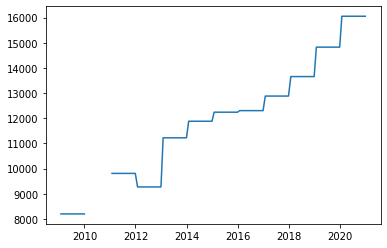

In [35]:
#STB was missing book value from 2011 to 2012
plt.plot(com_book_val.index, com_book_val['STB'])

In [36]:
#There are 3 companies miss book's value in middle more than 12 months
l = []
for code in com_book_val.columns:
  if com_book_val[code][com_book_val[code].first_valid_index():com_book_val[code].last_valid_index()].isna().sum() >12:
    l.append(code)
print(l)

['BCM', 'HAR', 'VFG']


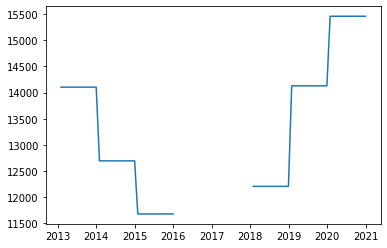

In [37]:
#BCM was missing book value from 2016 to 2018
plt.plot(com_book_val.index, com_book_val['BCM'])

In [38]:
#No company missing book value more than 24 months in middle, so we can fill company missing book value in middle easily. We will fill with previous year's value.

for code in com_book_val.columns:
  if com_book_val[code][com_book_val[code].first_valid_index():com_book_val[code].last_valid_index()].isna().sum() != 0:
    com_book_val[code][com_book_val[code].first_valid_index():com_book_val[code].last_valid_index()].fillna(method="ffill", inplace=True)    

In [39]:
#Company not delist but missing value
l = []
for code in com_book_val.columns:
  if len(code.split()) ==1:
    if com_book_val[code][com_book_val[code].first_valid_index():].isna().sum() > 0:                                    
      l.append(code)
l

['PDN', 'FIR', 'HSG', 'SFC', 'TIX']

In [40]:
#Most companies only miss quarter 4 of 2020, so we fill these companies's missing value
com_book_val['HSG']

Date
2006-12-29     658.914
2007-01-31    1847.281
2007-02-28    1847.281
2007-03-30    1847.281
2007-04-30    1847.281
                ...   
2020-08-31    13471.95
2020-09-30    13471.95
2020-10-30         NaN
2020-11-30         NaN
2020-12-31         NaN
Name: HSG, Length: 169, dtype: object

In [41]:
#Fill company not delist missing value

for code in com_book_val.columns:
  if len(code.split()) == 1:
    com_book_val[code][com_book_val[code].first_valid_index():].fillna(method='ffill', inplace=True)                    
  else:
    pass


In [42]:
#Company all nan value from 12/2006-12/2020 because these companies just listing on HOSE from 1/2021
list(com_market_val[com_market_val.columns[com_market_val.isna().all()]].columns)                                             

['SSB', 'OCB', 'TNH', 'AAT', 'SVD']

In [43]:
drop_list = list(com_market_val[com_market_val.columns[com_market_val.isna().all()]].columns)

In [44]:
#Because these companies still have data in book value, we also drop in book value df
com_price = com_price.dropna(how='all',axis=1)
com_market_val = com_market_val.dropna(how='all',axis=1)
com_book_val = com_book_val.drop(drop_list , axis=1)

In [45]:
#Since company delist and book value take by year, we don't have monthly data of these company before delist
com_book_val['KSA 02/08/18']['2018']                                  

Date
2018-01-31    NaN
2018-02-28    NaN
2018-03-30    NaN
2018-04-30    NaN
2018-05-31    NaN
2018-06-29    NaN
2018-07-31    NaN
2018-08-31    NaN
2018-09-28    NaN
2018-10-31    NaN
2018-11-30    NaN
2018-12-31    NaN
Name: KSA 02/08/18, dtype: object

In [46]:
#We'll fill these month book value with data of previous year

for code in com_book_val.columns:
  code_split = code.split()
  try:
    date = code_split[1]
    date = datetime.strptime(date, "%d/%m/%y").strftime("%m-%d-%y")
    com_book_val[code][com_book_val[code].first_valid_index():date].fillna(method='ffill', inplace=True)                    
  except:
    pass

In [47]:
#Delist monthly after fill
com_book_val['KSA 02/08/18']['2018']                                                                                        

Date
2018-01-31    10612.688
2018-02-28    10612.688
2018-03-30    10612.688
2018-04-30    10612.688
2018-05-31    10612.688
2018-06-29    10612.688
2018-07-31    10612.688
2018-08-31          NaN
2018-09-28          NaN
2018-10-31          NaN
2018-11-30          NaN
2018-12-31          NaN
Name: KSA 02/08/18, dtype: object

In [48]:
#Although delist, data after delist date still fill with previous value
com_market_val['KSA 02/08/18'][com_market_val['KSA 02/08/18'].first_valid_index():]                              


Date
2010-07-27    772127.4
2010-07-28    733521.5
2010-07-29    701349.2
2010-07-30    733521.5
2010-08-02    733521.5
                ...   
2020-12-25    44845.09
2020-12-28    44845.09
2020-12-29    44845.09
2020-12-30    44845.09
2020-12-31    44845.09
Name: KSA 02/08/18, Length: 2723, dtype: object

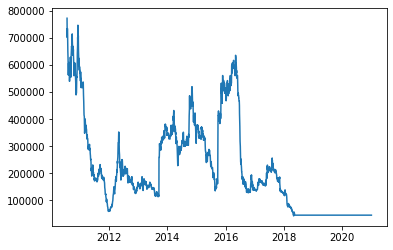

In [49]:
plt.plot(com_market_val.index, com_market_val['KSA 02/08/18'])

In [50]:
 #We'll fill these data after delist with NaN in market df
for code in com_market_val.columns:
  code_split = code.split()
  try:
    date = code_split[1]
    date = datetime.strptime(date, "%d/%m/%y").strftime("%m-%d-%y")                      
    com_market_val[code][date:] = np.nan
  except:
    pass

In [51]:
#Month after delist date fill with nan
com_market_val['KSA 02/08/18'][com_market_val['KSA 02/08/18'].first_valid_index():]                              


Date
2010-07-27    772127.4
2010-07-28    733521.5
2010-07-29    701349.2
2010-07-30    733521.5
2010-08-02    733521.5
                ...   
2020-12-25         NaN
2020-12-28         NaN
2020-12-29         NaN
2020-12-30         NaN
2020-12-31         NaN
Name: KSA 02/08/18, Length: 2723, dtype: object

In [52]:
#We'll also fill these data after delist with NaN in price df
for code in com_price.columns:
  code_split = code.split()
  try:
    date = code_split[1]
    date = datetime.strptime(date, "%d/%m/%y").strftime("%m-%d-%y")                       
    com_price[code][date:] = np.nan
  except:
    pass

In [53]:
#We'll also fill these data after delist with NaN in book df
for code in com_book_val.columns:
  code_split = code.split()
  try:
    date = code_split[1]
    date = datetime.strptime(date, "%d/%m/%y").strftime("%m-%d-%y")                       
    com_book_val[code][date:] = np.nan
  except:
    pass

In [54]:
#Create monthly index from 12/2006 to 12-2020
index_dummy = pd.date_range(start='2006-12-21', end='2020-12-31', freq='M')             
index_dummy

DatetimeIndex(['2006-12-31', '2007-01-31', '2007-02-28', '2007-03-31',
               '2007-04-30', '2007-05-31', '2007-06-30', '2007-07-31',
               '2007-08-31', '2007-09-30',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=169, freq='M')

In [55]:
#We choose date on 26th of month to represent data of this month
index_26th =  pd.Index([datetime(x.year, x.month, 26) for x in index_dummy.tolist()])     
index_26th

DatetimeIndex(['2006-12-26', '2007-01-26', '2007-02-26', '2007-03-26',
               '2007-04-26', '2007-05-26', '2007-06-26', '2007-07-26',
               '2007-08-26', '2007-09-26',
               ...
               '2020-03-26', '2020-04-26', '2020-05-26', '2020-06-26',
               '2020-07-26', '2020-08-26', '2020-09-26', '2020-10-26',
               '2020-11-26', '2020-12-26'],
              dtype='datetime64[ns]', length=169, freq=None)

In [56]:
#Now we take data on 26th date of month, if on this date don't have data, we'll using data from nearest date.
#For example: 26-9-2020 is on Saturday, it will take data from 25-9-2020 on Friday, 
#if 26th date on Sunday, it'll take data from Monday

com_price = com_price.reindex(index_26th, method='nearest')  
com_market_val = com_market_val.reindex(index_26th, method= 'nearest')
com_book_val = com_book_val.reindex(index_26th, method= 'nearest')
vnindex = vnindex.reindex(index_26th, method='nearest')
bond = bond.reindex(index_26th, method= 'nearest')

In [57]:
#After reindex, 'BKG' is all NaN since it just listing on HOSE on 31/12/2020(https://kinhtexaydung.petrotimes.vn/co-phieu-bkg-chinh-thuc-len-san-hose-592434.html)
#and we use nearest fill so on 26/12/2020 we don't have 'BKG' data. Therefore, we will drop this company
com_market_val[com_market_val.columns[com_market_val.isna().all()]].columns  

Index(['BKG'], dtype='object')

In [58]:
com_price = com_price.drop('BKG' , axis=1)
com_book_val = com_book_val.drop('BKG' , axis=1)
com_market_val = com_market_val.drop('BKG' , axis=1)

In [59]:
print(com_price.shape)
print(com_market_val.shape)
print(com_book_val.shape)
print(bond.shape)
print(vnindex.shape)

(169, 415)
(169, 415)
(169, 415)
(169, 1)
(169, 1)


# 2. Calculate
We divide problem into small problem. Instead of calculate all months once time, we build a fuction to calculate each month, then calculate all months then.

In [60]:
#Create company'stock return DataFrame
price_return = com_price.pct_change()


In [61]:
def calculate(date):
  index_avail = []
  t_1 = datetime(date.year-1, date.month, 26)            #Take t-1 year
  #Take market, book value, price, return of date choosen
  market = pd.DataFrame(com_market_val.loc[date], dtype=float)
  book = pd.DataFrame(com_book_val.loc[t_1.strftime('%Y')].iloc[0], dtype=float) #Take t-1 year book value
  price = pd.DataFrame(com_price.loc[date], dtype=float)
  return_price = pd.DataFrame(price_return.loc[date], dtype=float)

  #Because some companies don't have market data but still have book data. Or some companies just listing on HOSE and don't have previous month data so don't have return,
  #We will check which companies have enough these data
  m_avail_code = market[date][market[date].notnull()].index
  b_avail_code = book[book.iloc[:,0].notnull()].index
  p_return_avail = return_price[date][return_price[date].notnull()].index

  for code in m_avail_code:
    if code in b_avail_code and code in p_return_avail:                   #Check if companies have market data also have book value and return.
      index_avail.append(code)
  
  index_avail = pd.Index(index_avail)                                     #Turn these companies into Index
  
  df = market.loc[index_avail]                                            #Take companies in market df with availabel index
  df = df.rename(columns={date:'Market_value'})                           #Rename columns to Market_value

  mean_market = df['Market_value'].mean()                                 #Calculate mean market value of all availabe companies

  def market_classify(n):                                                 #Create fuction to classify companies to Big or Small
    if n > mean_market:
      return 'B'
    else:
      return 'S'
  df['Size'] = df['Market_value'].apply(market_classify)                  #Apply fuction
  
  df['B/M'] = book.loc[index_avail].values / price.loc[index_avail].values              #Calculate B/M and put in B/M column

  S = df.groupby(['Size']).get_group('S')                                 #Take small companies to S df
  S = S.sort_values(by='B/M')                                             #Sort companies by B/M
  S['Type'] = np.nan                                                      #Create Type column
  S['Type'][:round(len(S)*0.3)] = 'SL'                                    #Set 30% small companies to SL type
  S['Type'][round(len(S)*0.3):round(len(S)*0.7)] = 'SM'                   #40% to SM type
  S['Type'][round(len(S)*0.7):] = 'SH'                                    #30% remain to SH

  B = df.groupby(['Size']).get_group('B')                                 #Similar to Small group
  B = B.sort_values(by='B/M')
  B['Type'] = np.nan
  B['Type'][:round(len(B)*0.3)] = 'BL'
  B['Type'][round(len(B)*0.3):round(len(B)*0.7)] = 'BM'
  B['Type'][round(len(B)*0.7):] = 'BH'

  S['Return'] = return_price.loc[S.index]                                 #Create return column
  B['Return'] = return_price.loc[B.index]

  SBM =(S.groupby("Type").mean())['Return'].sum()/3 - (B.groupby("Type").mean())['Return'].sum()/3         #Calculate SBM = (SL+SM+SH)/3-(BL+BM+BH)/3
  
  #Calculate HML = (SH+BH)/2 - (SL+BL)/2
  HML = (S.groupby("Type").mean()['Return']['SH'] + B.groupby("Type").mean()['Return']['BH'])/2 - (S.groupby("Type").mean()['Return']['SL'] + B.groupby("Type").mean()['Return']['BL'])/2

  R = (S.groupby("Type").mean()['Return'].sum() + B.groupby("Type").mean()['Return'].sum())/6               #Calculate average return of all portfolio

  r_mkt = vnindex.pct_change().loc[date].values[0]                        
  r_f = bond['Bond'].loc[date]/1200
  RmRf = r_mkt-r_f
  RRf = R-r_f

  return R,r_mkt,r_f,RRf,RmRf,SBM,HML



In [62]:
R_list= []
r_mkt_list=[]
r_f_list = []
RRf_list = []
RmRf_list = []
SBM_list = []
HML_list = []

#Because bond only have date from 3/2007 and too little companies, we will start calculate from 5/2007

for i in range(5,len(index_26th),1):
  date = index_26th[i]
  result = calculate(date)
  R_list.append(result[0])
  r_mkt_list.append(result[1])
  r_f_list.append(result[2])
  RRf_list.append(result[3])
  RmRf_list.append(result[4])
  SBM_list.append(result[5])
  HML_list.append(result[6])
  
#Create DataFrame
FF_df = pd.DataFrame({'R':R_list,'r_mkt':r_mkt_list,'r_f':r_f_list,'R-Rf':RRf_list,'Rm-Rf':RmRf_list,'SBM':SBM_list,'HML':HML_list},index=index_26th[5:])


In [63]:
FF_df

,R,r_mkt,r_f,R-Rf,Rm-Rf,SBM,HML
2007-05-26,0.104124,0.179361,0.006750,0.097374,0.172611,0.069038,0.039042
2007-06-26,-0.023191,-0.031112,0.006708,-0.029900,-0.037821,0.202104,-0.186504
2007-07-26,-0.048236,-0.094317,0.007083,-0.055320,-0.101400,0.056874,0.011538
2007-08-26,-0.019024,-0.049219,0.007208,-0.026233,-0.056428,0.019389,-0.082403
2007-09-26,0.116533,0.117527,0.007250,0.109283,0.110277,0.026899,0.028901
...,...,...,...,...,...,...,...
2020-08-26,0.130713,0.112460,0.002394,0.128319,0.110066,-0.014265,0.010993
2020-09-26,0.063110,0.039841,0.002286,0.060824,0.037555,-0.040665,-0.024014
2020-10-26,0.029346,0.046825,0.002145,0.027201,0.044680,-0.043096,-0.006487
2020-11-26,0.055954,0.058025,0.002017,0.053937,0.056007,-0.016805,-0.032441


# III. Modeling

In [64]:
X = FF_df.iloc[:,4:]

In [65]:
X = sm.add_constant(X)

In [66]:
y = FF_df['R-Rf']

In [67]:
model = sm.OLS(y,X).fit()

In [68]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   R-Rf   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     792.2
Date:                Fri, 29 Oct 2021   Prob (F-statistic):           9.56e-96
Time:                        08:31:40   Log-Likelihood:                 391.61
No. Observations:                 164   AIC:                            -775.2
Df Residuals:                     160   BIC:                            -762.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.002      5.579      0.0